# Model training

This notebook is used to train and compare a set of models on the data splits. This step is done to identify the best performing model.

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from pycaret.classification import setup, compare_models, pull

import seaborn as sns
import matplotlib.pyplot as plt

# Model Training and comparison 

In [2]:
def train_model_pipeline(
    data: pd.DataFrame, test_data: pd.DataFrame, metric: str, exp_name: str
):
    """PyCaret pipeline for training a model on a dataset, selecting the bet and saving it to disk."""

    setup(
        data=data,
        target="label",
        test_data=test_data,
        index=False,
        train_size=0.8,  # train-validation split
        low_variance_threshold=0,
        fold_strategy="stratifiedkfold",  # CV strategy
        fold=5,  # CV strategy
        experiment_name=exp_name,
        verbose=False,
    )

    compare_models(
        sort=metric,
        round=2,  # number of decimal places for metric
        include=["nb", "lr", "lightgbm", "dt", "rf", "xgboost"],
        fold=5,
        verbose=False,
    )  # Gets the best model based on the metric for hold-out set

    eval_results = pull()
    return eval_results

In [3]:
eval_results = {}

for fingerprint_name in tqdm(["ecfp4", "rdkit", "maccs", "mhfp6", "erg", "chem_phys"]):
    # Splitting train data into train and validation sets
    train_data = pd.read_csv(f"../data/splits/{fingerprint_name}_train.csv")
    train_data.drop(columns=["cmp_id"], inplace=True)
    train_data, valid_data = train_test_split(
        train_data, test_size=0.2, stratify=train_data["label"], random_state=42
    )

    train_with_smote = pd.read_csv(f"../data/splits/{fingerprint_name}_smote_train.csv")
    smote_train_data, smote_valid_data = train_test_split(
        train_with_smote,
        test_size=0.2,
        stratify=train_with_smote["label"],
        random_state=42,
    )

    results = train_model_pipeline(
        data=train_data,
        test_data=valid_data,
        metric="Kappa",
        exp_name=f"{fingerprint_name}",
    )

    eval_results[f"{fingerprint_name}"] = results

    smote_results = train_model_pipeline(
        data=train_with_smote,
        test_data=smote_valid_data,
        metric="Kappa",
        exp_name=f"{fingerprint_name}_with_smote",
    )

    eval_results[f"{fingerprint_name}_smote"] = smote_results

100%|██████████| 6/6 [1:16:22<00:00, 763.83s/it] 


# Hold-off set performance evaluation

In [4]:
final_eval_df = []

for fingerprint_name, results in eval_results.items():
    for (
        model_name,
        acc,
        auc,
        recall,
        precision,
        f1,
        kappa,
        mcc,
        time,
    ) in results.values:
        if "chem_phy" in fingerprint_name:
            fingerprint_name = fingerprint_name.replace("chem_phy", "chemphy")

        final_eval_df.append(
            {
                "fingerprint": (
                    fingerprint_name
                    if "smote" not in fingerprint_name
                    else fingerprint_name.split("_")[0]
                ),
                "Train type": "SMOTE" if "smote" in fingerprint_name else "Orginal",
                "Model": model_name,
                "kappa": kappa,
            }
        )

final_eval_df = pd.DataFrame(final_eval_df)
final_eval_df["fingerprint"] = final_eval_df["fingerprint"].map(
    {
        "ecfp4": "ECFP4",
        "rdkit": "RDKit",
        "maccs": "MACCS",
        "mhfp6": "MHFP6",
        "chemphys": "ChemPhys",
        "erg": "ErG",
    }
)

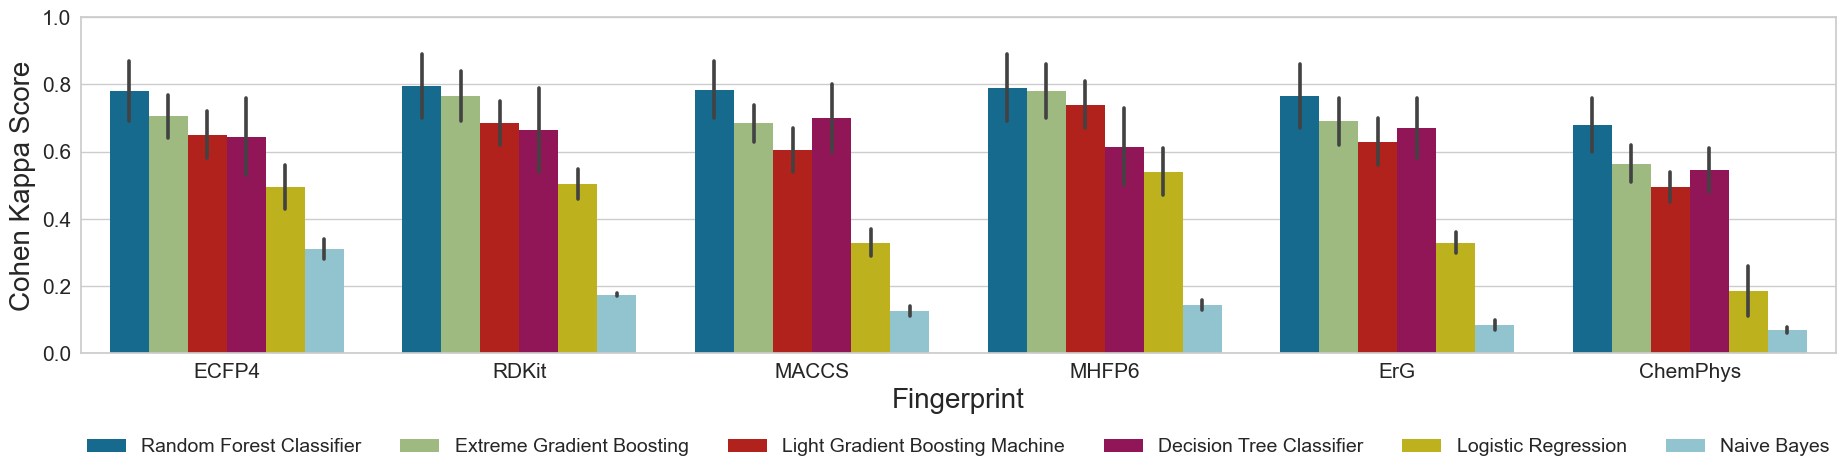

In [5]:
plt.figure(figsize=(20, 5))
sns.barplot(
    data=final_eval_df,
    x="fingerprint",
    y="kappa",
    hue="Model",
)
plt.ylabel("Cohen Kappa Score", fontsize=20)
plt.xlabel("Fingerprint", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 1)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=True,
    ncol=6,
    fontsize=14,
)

plt.tight_layout()

plt.savefig("../figures/figure_5.png", dpi=400)
plt.show()

In [6]:
final_eval_df.sort_values("kappa", ascending=False).head(10)

,fingerprint,Train type,Model,kappa
18,RDKit,SMOTE,Random Forest Classifier,0.89
42,MHFP6,SMOTE,Random Forest Classifier,0.89
6,ECFP4,SMOTE,Random Forest Classifier,0.87
30,MACCS,SMOTE,Random Forest Classifier,0.87
54,ErG,SMOTE,Random Forest Classifier,0.86
43,MHFP6,SMOTE,Extreme Gradient Boosting,0.86
19,RDKit,SMOTE,Extreme Gradient Boosting,0.84
44,MHFP6,SMOTE,Light Gradient Boosting Machine,0.81
31,MACCS,SMOTE,Decision Tree Classifier,0.80
20,RDKit,SMOTE,Decision Tree Classifier,0.79


### SMOTE against no SMOTE comparison for top performing ones

RF and XGBoost seem to be consistently performing best for all fingerprints.

In [7]:
m = final_eval_df["Model"].isin(
    ["Random Forest Classifier", "Extreme Gradient Boosting"]
)
top_models = final_eval_df[m]

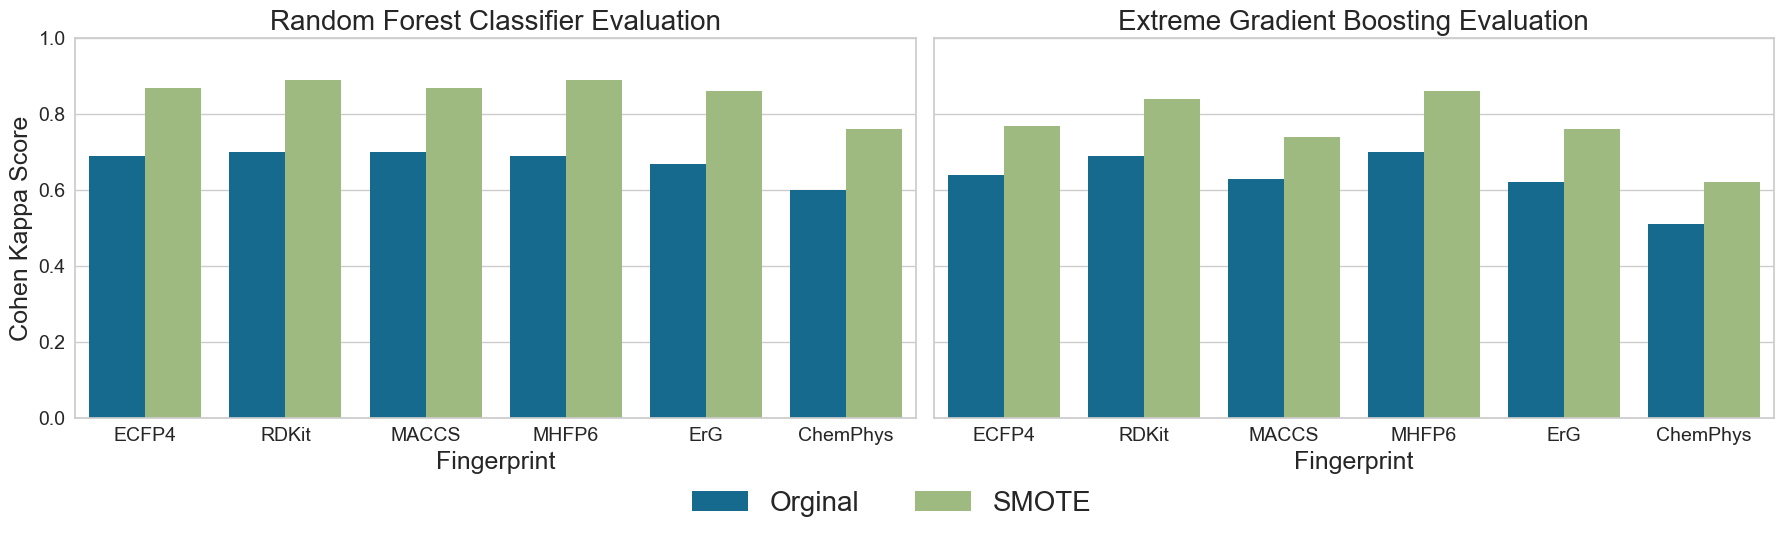

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(
    data=top_models[top_models["Model"] == "Random Forest Classifier"],
    x="fingerprint",
    y="kappa",
    hue="Train type",
    hue_order=["Orginal", "SMOTE"],
    ax=ax1,
)
ax1.set_ylabel("Cohen Kappa Score", fontsize=18)
ax1.set_xlabel("Fingerprint", fontsize=18)
# increase font size of x ticks
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax1.set_ylim(0, 1)

# remove legend
ax1.get_legend().remove()

ax1.set_title("Random Forest Classifier Evaluation", fontsize=20)

sns.barplot(
    data=top_models[top_models["Model"] == "Extreme Gradient Boosting"],
    x="fingerprint",
    y="kappa",
    hue="Train type",
    hue_order=["Orginal", "SMOTE"],
    ax=ax2,
)
ax2.set_ylabel("")
ax2.set_xlabel("Fingerprint", fontsize=18)

# remove y tick labels
ax2.set_yticklabels([])

# increase font size of x ticks
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

ax2.set_ylim(0, 1)
ax2.set_title("Extreme Gradient Boosting Evaluation", fontsize=20)

# remove legend
ax2.get_legend().remove()

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=20,
)

plt.tight_layout()
plt.savefig("../figures/supplementary_figure_2.png", dpi=400, bbox_inches="tight")
plt.show()

In [9]:
final_eval_df.to_csv(
    "../data/processed/model_comparison_results.tsv", sep="\t", index=False
)